In this notebook, we will use GloVe with LSTM. 

# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import string


import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from gensim.models import word2vec

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Flatten
from tensorflow.keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Sequential
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow_hub as hub
import tensorflow_datasets as tfds


from  IPython import display

import pathlib
import shutil
import tempfile

!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
 
print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)


import warnings
warnings.filterwarnings('ignore')

Version:  2.8.2
Hub version:  0.12.0
GPU is available


In [ ]:
!nvidia-smi

Sat Jul  9 10:16:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Functions We Use

The functionsthat we use in this notebook are located in this section. The first function is the neural network that we will train on the training set. The next two functions perform some basic cleaning and the last function prints the result of the training.

### Cleaning the data

In [ ]:
def new_cleaning(data):
    cleaned_data = data.replace("[", "").replace("]", "").replace("'", "")\
                                    .replace(" ", "").split(",")

    cleaned_sentence = " ".join(cleaned_data)


    return cleaned_sentence

### Printing the results

In [ ]:
def print_results(model): 
    
    
    train_loss = model.history.history["loss"]
    train_acc  = model.history.history["accuracy"]

    test_loss = model.history.history["val_loss"]
    test_acc  = model.history.history["val_accuracy"]
    
    
    sns.set(font_scale=1)
    
    cf_matrix_test  = confusion_matrix(y_test, np.rint(model.predict(padded_test)))
    cf_matrix_train = confusion_matrix(y_train, np.rint(model.predict(padded_train)))
    
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
    ax1 = axes[0][0]
    
    g = sns.heatmap(cf_matrix_test, annot=True, cmap='Blues', ax = ax1)
    
    g.xaxis.set_ticklabels(['Fake','True'])
    g.yaxis.set_ticklabels(['Fake','True'])

    
    ax1.set_title("Confusion Matrix for Test Set")
    
    ax2 = axes[0][1]
    g = sns.heatmap(cf_matrix_train, annot=True, cmap='Blues', ax = ax2)
    g.xaxis.set_ticklabels(['Fake','True'])
    g.yaxis.set_ticklabels(['Fake','True'])

    
    ax2.set_title("Confusion Matrix for Train Set")
    
    
    
    ax3 = axes[1][0]
    
    g = sns.lineplot(x = range(1,len(train_loss)+1), 
                     y = train_loss, 
                     label = "train_loss", ax = ax3);
    g = sns.lineplot(x = range(1,len(test_loss)+1), 
                     y = test_loss, 
                     label = "test_loss", ax = ax3);


    
    ax3.set_title("Loss vs. Epochs")
    
    
    
    ax4 = axes[1][1]
    
    g = sns.lineplot(x = range(1,len(train_acc)+1), 
                     y = train_acc, 
                     label = "train_accuracy", ax = ax4);
    g = sns.lineplot(x = range(1,len(test_acc)+1), 
                     y = test_acc, 
                     label = "test_accuracy", ax = ax4);
    
    
    ax4.set_title("Accuracy vs. Epochs")
    
    
    ### Presenting Classification Report as a DataFrame
    train_class = classification_report(y_train, np.rint(model.predict(padded_train)), 
                                        output_dict = True)
    test_class  = classification_report(y_test, np.rint(model.predict(padded_test)), 
                                        output_dict = True)
    
    train_df = pd.DataFrame(train_class)
    test_df  = pd.DataFrame(test_class)
    
    train_df["data"] = "TRAIN"
    test_df["data"] = "TEST"
    

    report = pd.concat([test_df, train_df], axis = 0)
    report.rename(columns = {"1": f"{list(le.inverse_transform([1]))[0]}",
                             "0": f"{list(le.inverse_transform([0]))[0]}"}, inplace = True)
    report["index"] = list(report.index)

    report.set_index(["data", "index"], inplace = True)
    
    
    for item in list(report.columns):
        report[item] = report[item].apply(lambda x: np.round(x,2))
    
    return report

# Importing Data

In [ ]:
test = pd.read_csv("/content/drive/MyDrive/Fake-Real-News-Classification/Modeling/train_test/test.csv")
train = pd.read_csv("/content/drive/MyDrive/Fake-Real-News-Classification/Modeling/train_test/train.csv")


data  = [train, test]

for df in data:
    
    df.drop("Unnamed: 0", axis = 1, inplace = True)
    df["cleaned"] =  df["cleaned"].apply(lambda x: new_cleaning(x))
    
    df["cleaned_glove"] =  df["for_glove"].apply(lambda x: new_cleaning(x))
   

print("DONE!")

DONE!


In [ ]:
le = LabelEncoder()

X_train = train["cleaned"].values
y_train = le.fit_transform(train["label"])

X_test = test["cleaned"].values
y_test = le.transform(test["label"])

In [ ]:
X_train[0].split()

['april', 'giraffe', 'zoo', 'want', 'name', 'calf']

# Importing GloVe

In [ ]:
total_vocabulary = set(word for headline in X_train for word in headline.split())
print(len(total_vocabulary))


glove = {}
with open('/content/drive/MyDrive/Fake-Real-News-Classification/Modeling/glove.840B.300d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector
            
            

print("DONE!")   

94186
DONE!


In [ ]:
len(list(glove.keys()))
glove[list(glove.keys())[0]].shape[0]

300

In [ ]:
max_features = 1000
# max_len = glove[list(glove.keys())[0]].shape[0]
max_len = 250

## Train Set
tokenizer = text.Tokenizer(num_words= max_features)#, oov_token= "<OOV>")


tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index

tokenized_train = tokenizer.texts_to_sequences(X_train)
padded_train = pad_sequences(tokenized_train, maxlen = max_len, truncating="post")


## Test Set
tokenized_test = tokenizer.texts_to_sequences(X_test)
padded_test    = pad_sequences(tokenized_test,maxlen=max_len)

print(len(word_index))

93782


In [ ]:
embedding_dim = glove[list(glove.keys())[0]].shape[0]
embedding_matrix = np.zeros((len(word_index) + 1 , embedding_dim))

for key, val in word_index.items():

   if key in glove.keys():
      embedding_matrix[val] = glove[key]  

In [ ]:
embedding_layer = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],
                            weights = [embedding_matrix],
                            input_length = max_len,
                            trainable = False)

In [ ]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], 
                    weights=[embedding_matrix], input_length=max_len, trainable=False))
#LSTM 
model.add(LSTM(units=64 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.5))
model.add(LSTM(units=32 , recurrent_dropout = 0.1 , dropout = 0.5))
model.add(Flatten())
model.add(Dense(units = 40 , activation = 'relu'))
model.add(Dropout(0.5))
# model.add(Dense(units = 20 , activation = 'relu'))
# model.add(Dropout(0.5))
# model.add(Dense(units = 10 , activation = 'relu'))
# model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.001), loss='binary_crossentropy', metrics=['accuracy'])

Epoch 1/40
15/15 [==============================] - 39s 2s/step - loss: 0.6275 - accuracy: 0.6813 - val_loss: 0.5044 - val_accuracy: 0.7864
Epoch 2/40
15/15 [==============================] - 33s 2s/step - loss: 0.4936 - accuracy: 0.7893 - val_loss: 0.4319 - val_accuracy: 0.8145
Epoch 3/40
15/15 [==============================] - 32s 2s/step - loss: 0.4429 - accuracy: 0.8133 - val_loss: 0.4520 - val_accuracy: 0.8136
Epoch 4/40
15/15 [==============================] - 33s 2s/step - loss: 0.4065 - accuracy: 0.8320 - val_loss: 0.3824 - val_accuracy: 0.8333
Epoch 5/40
15/15 [==============================] - 33s 2s/step - loss: 0.4264 - accuracy: 0.8000 - val_loss: 0.3804 - val_accuracy: 0.8269
Epoch 6/40
15/15 [==============================] - 32s 2s/step - loss: 0.3787 - accuracy: 0.8287 - val_loss: 0.3872 - val_accuracy: 0.8177
Epoch 7/40
15/15 [==============================] - 32s 2s/step - loss: 0.3573 - accuracy: 0.8412 - val_loss: 0.3629 - val_accuracy: 0.8234
Epoch 8/40
15/15 [==

Fake      True  accuracy  macro avg  weighted avg
data  index                                                           
TEST  precision      0.87      0.88      0.88       0.88          0.88
      recall         0.81      0.92      0.88       0.87          0.88
      f1-score       0.84      0.90      0.88       0.87          0.88
      support     8719.00  13194.00      0.88   21913.00      21913.00
TRAIN precision      0.90      0.89      0.89       0.90          0.89
      recall         0.82      0.94      0.89       0.88          0.89
      f1-score       0.86      0.91      0.89       0.89          0.89
      support    17502.00  26987.00      0.89   44489.00      44489.00

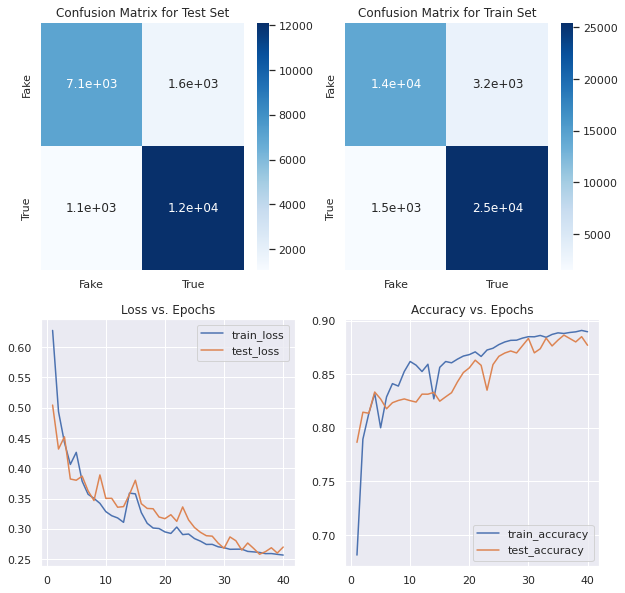

In [ ]:
model.fit(padded_train, y_train, epochs=40, batch_size=3000,
         validation_data=(padded_test, y_test))
print("fitting to the model is DONE!")
print_results(model)

In [ ]:
import pickle
from joblib import dump, load
dump(model, '/content/drive/MyDrive/Fake-Real-News-Classification/pickled_nn_models/model__nn_glove.joblib')

INFO:tensorflow:Assets written to: ram://62078037-38f8-4f89-97de-9487083fad15/assets


['/content/drive/MyDrive/Fake-Real-News-Classification/pickled_nn_models/model__nn_glove.joblib']